# Model Results Page
## Modules used were influenced by an exploration kernel on the kaggle competition dashboard:
https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
sns.set()

# Load Data
train_path = 'train/'
train_labels = pd.read_csv('./train.csv')
labels_path = './train.csv'




In [107]:
train_labels.shape[0]

31072

In [108]:
splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

In [109]:
partitions = []

for train_idx, test_idx in splitter.split(train_labels.index.values):
    partition = {}
    partition["train"] = train_labels.Id.values[train_idx]
    partition["validation"] = train_labels.Id.values[test_idx]
    partitions.append(partition)
#     print("TRAIN:", train_idx, "TEST:", test_idx)
#     print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

In [110]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [111]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)

In [112]:
baseline_proba_predictions = pd.read_csv("./baseline_predictions.csv", index_col=0)
validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])]

In [113]:
# print(validation_labels.shape)
# print(baseline_proba_predictions.shape)

In [115]:
proba_predictions = baseline_proba_predictions.values

In [116]:
hot_values = validation_labels.drop(["Id", "Target","number_of_targets"], axis=1).values.flatten()
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

Text(0.5, 1.0, 'Predicted probabilities')

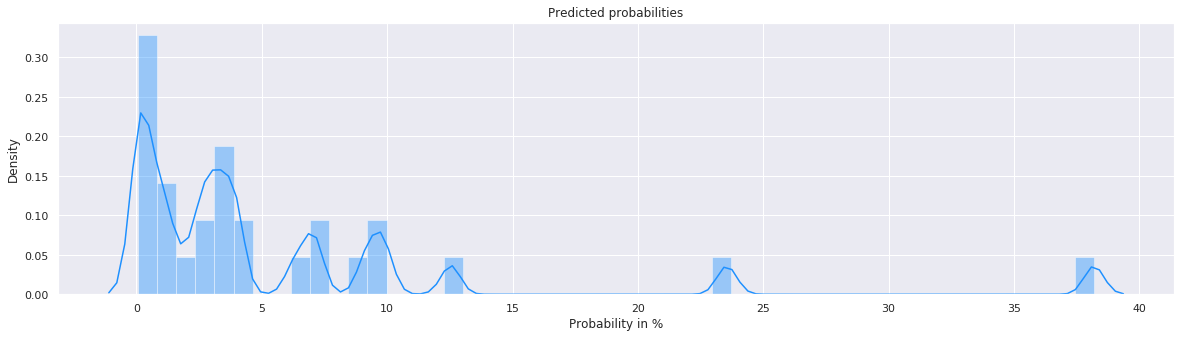

In [117]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax)
ax.set_xlabel("Probability in %")
ax.set_ylabel("Density")
ax.set_title("Predicted probabilities")


The above graph shows that our current model is not as certain when it predicts the presence of a target protein. there are higher probability densities closer to zero, but we do see peaks above 20 and above 40. We think that our current model is very good at one set of labels and quite poor at all others.

Text(0.5, 1.0, 'Standard deviation of predicted probability per class over all samples')

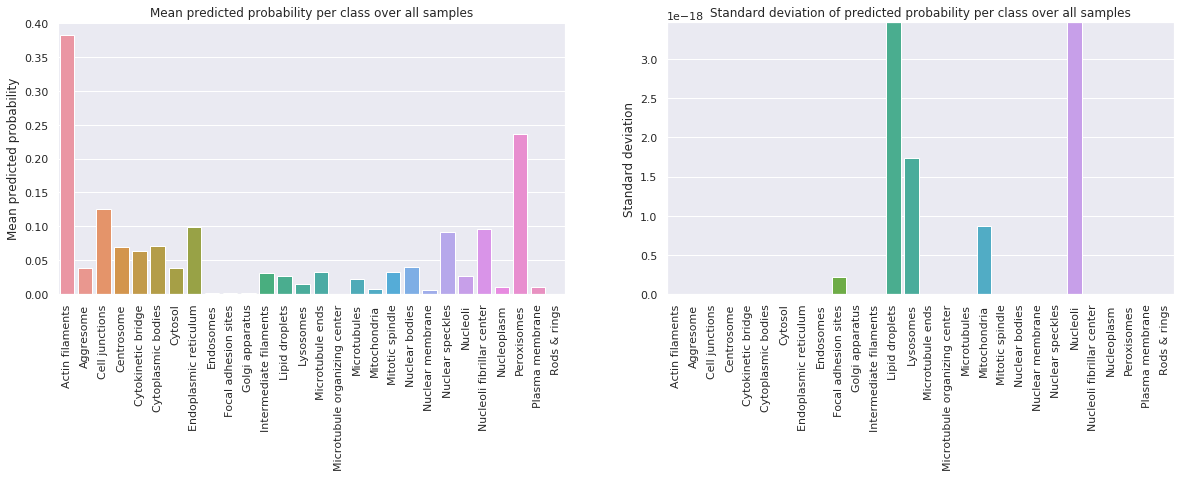

In [118]:
mean_predictions = np.mean(proba_predictions, axis=0)
std_predictions = np.std(proba_predictions, axis=0)
mean_targets = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).mean()

labels = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).columns.values

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=labels,
            y=mean_predictions,
            ax=ax[0])
ax[0].set_xticklabels(labels=labels,
                      rotation=90)
ax[0].set_ylabel("Mean predicted probability")
ax[0].set_title("Mean predicted probability per class over all samples")
sns.barplot(x=labels,
           y=std_predictions,
           ax=ax[1])
ax[1].set_xticklabels(labels=labels,
                      rotation=90)
ax[1].set_ylabel("Standard deviation")
ax[1].set_title("Standard deviation of predicted probability per class over all samples")

These graphs show our mean predicted probability across different labels. We see that we have a very high probability for Actin Filaments and almost none for Endosomes. We compared our results to other kernels on the leaderboard and it appears we have a similar distribution, but favor Aggresomes and a few others disproportionately. Furthermore, we have very high standard deviations of our predicted probabilities for a few labels and almost none for the others. This is an issue we are investigating, but we suspect it has to do with our feature augmentation.

Text(0.5, 1.0, 'Percentage of hot counts (ones) per target class')

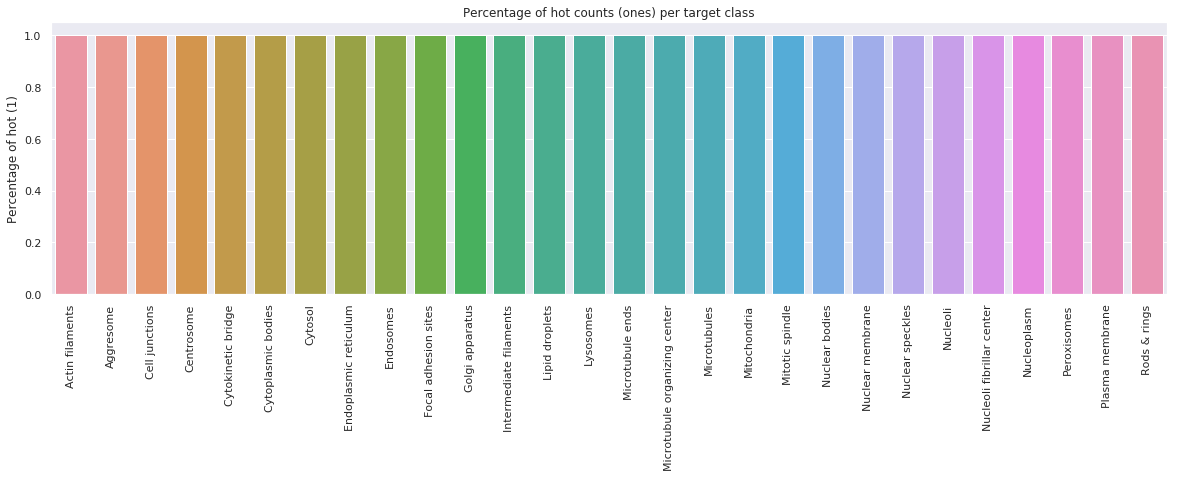

In [119]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x=labels, y=mean_targets.values, ax=ax)
ax.set_xticklabels(labels=labels,
                      rotation=90)
ax.set_ylabel("Percentage of hot (1)")
ax.set_title("Percentage of hot counts (ones) per target class")

One surprising thing about our validation dataset is that there are ones for each label. This developed during the most recent runs of this graph and we are trying to see what could be the cause.

In the next graph, we choose a random feature and try to see its probability. We saw that we were predicting the same probability across all images for a given label. This is a huge issue that we are working to fix.

(0, 1)

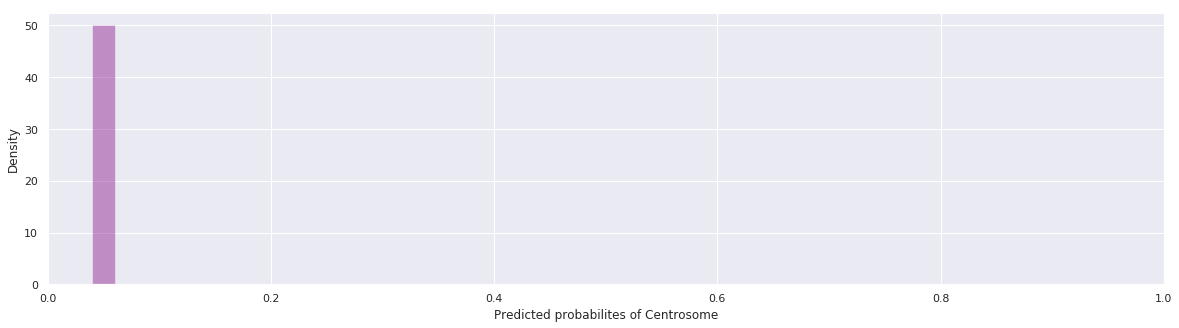

In [120]:
feature = "Centrosome"
plt.figure(figsize=(20,5))
sns.distplot(baseline_proba_predictions[feature].values[0:-10], color="Purple")
plt.xlabel("Predicted probabilites of {}".format(feature))
plt.ylabel("Density")
plt.xlim([0,1])

In [121]:
baseline_proba_predictions.head()

,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
1,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
2,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
3,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
4,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
